In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from resources.plotting import Plotter
from tqdm.autonotebook import tqdm

from nltk.tokenize import WordPunctTokenizer, WhitespaceTokenizer

from rouge_score.rouge_scorer import RougeScorer
from resources.bart_score import BARTScorer
from resources.testing import PearsonCorrelationTester
from sklearn.metrics import f1_score, precision_score, recall_score

/tmp/ipykernel_1896113/163327472.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
MODELS = {
    "Gemma - 2B":   "google/gemma-1.1-2b-it",
    "Gemma - 7B":   "google/gemma-1.1-7b-it",
    "Llama 3 - 8B": "meta-llama/Meta-Llama-3-8B-Instruct",
}

PLOTS_DIR  = "plots"

# Load results:

In [3]:
RESULTS = {}

for key in MODELS:
    with open(f'results/food incidents - hazard/{MODELS[key]}.pkl', 'rb') as file:
        RESULTS[key] = pickle.load(file)

In [4]:
pearson = PearsonCorrelationTester()
plotter = Plotter(RESULTS, save_dir=PLOTS_DIR)
plotter.print_chat("Llama 3 - 8B")

\begin{tabular}{p{.05\linewidth}p{.1\linewidth}p{.8\linewidth}}

\hline

&
\textbf{user}: &
\texttt{What is the reason for the recall of the food product in the following announcement?

"Sunny Fruit brand Dried and Organic Figs recalled due to presence of insects"

Assign one of the following labels: "biological", "allergens", "chemical", "foreign bodies", "organoleptic aspects", or "fraud". Make sure to answer only with the label.} \\

&
\textbf{assistant}: &
\texttt{"foreign bodies"} \\


\hline

&
\textbf{user}: &
\texttt{What is the most important phrase of the announcement influencing your assessment? Provide only the phrase as a string.} \\

&
\textbf{assistant}: &
\texttt{"presence of insects"} \\


\hline

&
\textbf{user}: &
\texttt{Provide a version of the announcement that would alter your assessment while changing as few words in the original announcement as possible. Make sure to answer with only the new version.} \\

&
\textbf{assistant}: &
\texttt{"Sunny Fruit brand Dried

# Performance:

## F1

In [5]:
for model in RESULTS:
    y_true = np.array([''.join(item['label']['tokens']) for item in RESULTS[model]])
    y_pred = np.array([''.join(item['prediction']['text'].split('\n\n')[0].strip('"*.')) for item in RESULTS[model]])
    
    print(model)
    print('  F1:              ', f1_score(y_true, y_pred, average='macro'))
    print('  precision:       ', precision_score(y_true, y_pred, average='macro'))
    print('  recall:          ', recall_score(y_true, y_pred, average='macro'))
    print()

Gemma - 2B
  F1:               0.3014982702482702
  precision:        0.29038606747046647
  recall:           0.3227995166837067

Gemma - 7B
  F1:               0.36246342447785296
  precision:        0.4593060271646859
  recall:           0.35871647509578547

Llama 3 - 8B
  F1:               0.34571192607477774
  precision:        0.3518714689265537
  recall:           0.3448275862068966



/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h21/kora8563/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h21/kora8563

# Faithfullness:

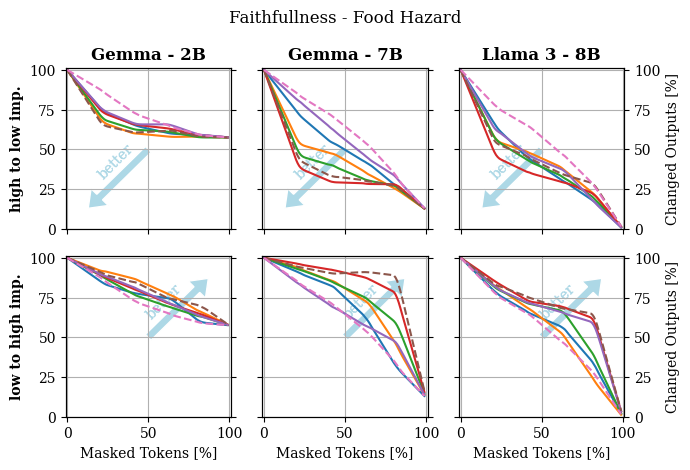

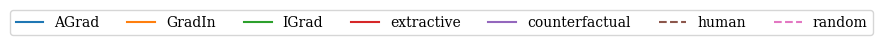

In [6]:
plotter.plot_perturbation('Faithfullness - Food Hazard')

Gemma - 2B

In [7]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma - 2B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['biological<eos>', '1200']], dtype='<U21')

Gemma - 7B

In [8]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma - 7B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['allergens<eos>', '48'],
       ['foreign bodies<eos>', '1152']], dtype='<U21')

Llama 3 - 8B

In [9]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Llama 3 - 8B"] for key in r['perturbation']],
    return_counts=True
)).T

array([["I'm happy to help! However, I don't see an announcement or a reason for a recall. Could you please provide the announcement you'd like me to analyze?<|eot_id|>",
        '6'],
       ["I'm happy to help! However, I don't see an announcement provided. Please share the announcement, and I'll be happy to label the reason for the recall accordingly.<|eot_id|>",
        '6'],
       ["Please provide the announcement, and I'll label the reason for the recall accordingly.<|eot_id|>",
        '1140'],
       ['allergens<|eot_id|>', '12'],
       ['biological<|eot_id|>', '36']], dtype='<U172')

# Self assessment:

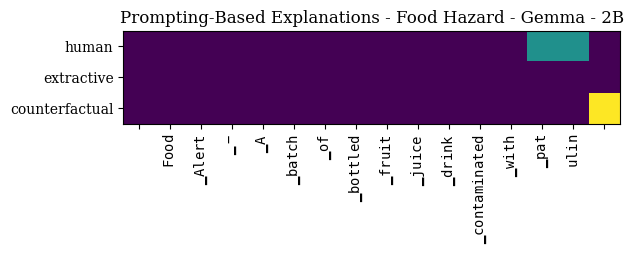

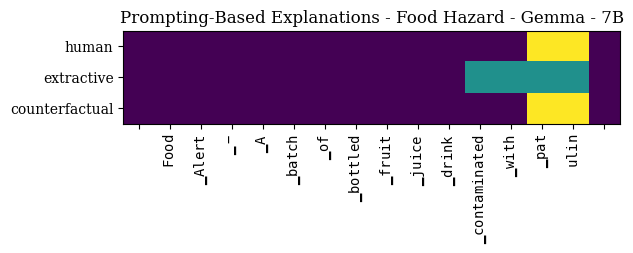

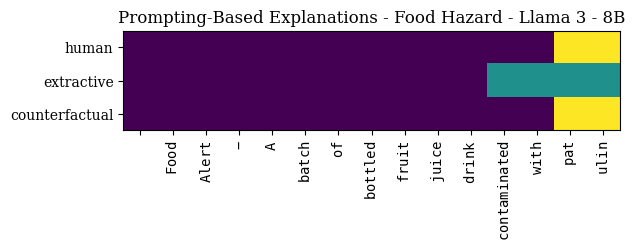

In [10]:
importance_human = {model:[] for model in RESULTS}
importance_self  = {model:[] for model in RESULTS}
importance_cf    = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        length = r['sample']['end'] - r['sample']['start']
        offset = r['sample']['start']
        
        importance_human[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['human']: 
            importance_human[model][-1][i-offset:j-offset] = 1.
        importance_human[model][-1] /= max(importance_human[model][-1].sum(), 1e-9)
        
        importance_self[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['extractive'][:len(r['spans']['human'])]:
            importance_self[model][-1][i-offset:j-offset] = 1.
        importance_self[model][-1] /= max(importance_self[model][-1].sum(), 1e-9)
        
        importance_cf[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['counterfactual']:
            importance_cf[model][-1][i-offset:j-offset] = 1.
        importance_cf[model][-1] /= max(importance_cf[model][-1].sum(), 1e-9)

plotter.plot_importance([importance_human, importance_self, importance_cf], ['human', 'extractive', 'counterfactual'], f'Prompting-Based Explanations - Food Hazard')
pearson.add(importance_human, 'human')
pearson.add(importance_self,  'extractive')
pearson.add(importance_cf,    'counterfactual')

# AGrad:

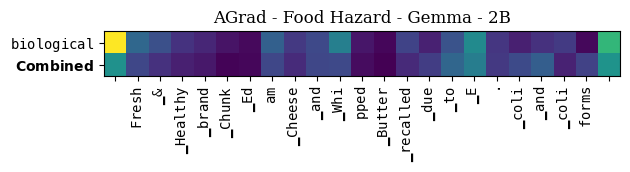

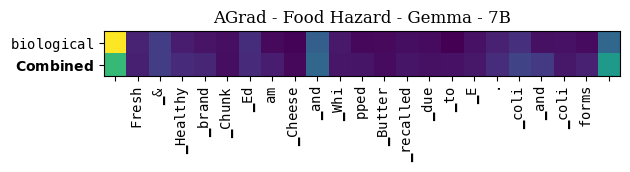

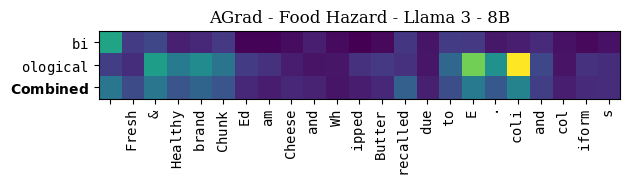

In [11]:
importance_agrad_raw = {model:[] for model in RESULTS}
importance_agrad     = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        x_start = r['sample']['start']
        x_end   = r['sample']['end']
    
        # get prediction boundaries:
        y_start = r['prediction']['index'] - 1 # outputs are shifted by one!
    #    y_end   = min(y_start + len(r['label']['tokens']), len(r['tokens']))
    
        # get importance:
        importance = np.abs(r['AGrad'][0, :, :, y_start:, x_start:x_end])
    
        # per token in label:
        importance_agrad_raw[model].append({
            r['label']['tokens'][i]: importance[i,:,i].mean(axis=0)
            for i in range(min(importance.shape[0], importance.shape[2]))
        })
    
        # combined:
        importance_agrad[model].append(np.cumsum(importance, axis=0).mean(axis=(0,1,2)))

plotter.plot_importance([importance_agrad_raw, importance_agrad], ['', '$\\bf{Combined}$'], f'AGrad - Food Hazard')
pearson.add(importance_agrad, 'AGrad')

# GradIn

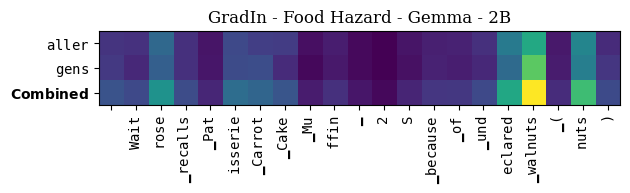

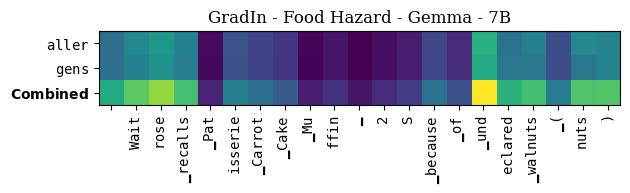

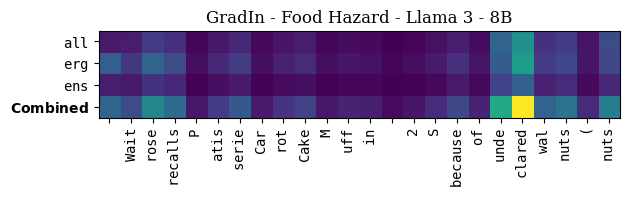

In [12]:
importance_gradin_raw = {model:[] for model in RESULTS}
importance_gradin     = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']
    
        # get importance:
        importance = np.abs(r['GradIn'][0, :, start:end, :])
    
        importance_gradin_raw[model].append({
            r['label']['tokens'][i]: importance[i,:,:].mean(axis=-1)
            for i in range(r['GradIn'].shape[1])
        })
    
        importance_gradin[model].append(importance.cumsum(axis=0).mean(axis=(0,-1)))

plotter.plot_importance([importance_gradin_raw, importance_gradin], ['', '$\\bf{Combined}$'], f'GradIn - Food Hazard')
pearson.add(importance_gradin, 'GradIn')

# Grad$^{-1}$

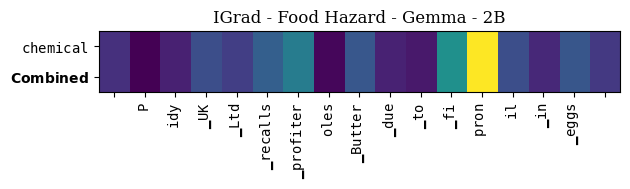

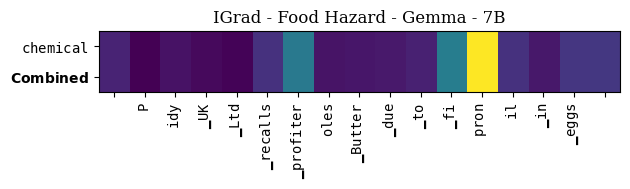

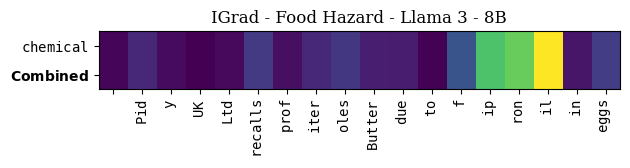

In [13]:
importance_igrad_raw = {model:[] for model in RESULTS}
importance_igrad     = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']
    
        # get importance:
        importance = r['IGrad'][0,start:end,:,:]
    
        importance_igrad_raw[model].append({
            r['label']['tokens'][i]: importance[:,:,i].mean(axis=-1)
            for i in range(r['IGrad'].shape[-1])
        })
    
        importance_igrad[model].append(importance.cumsum(axis=-1).mean(axis=(-1,-2)))

plotter.plot_importance([importance_gradin_raw, importance_gradin], ['', '$\\bf{Combined}$'], f'IGrad - Food Hazard')
pearson.add(importance_igrad, 'IGrad')

# Correlations:

/home/h21/kora8563/explainability/resources/testing.py:190: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


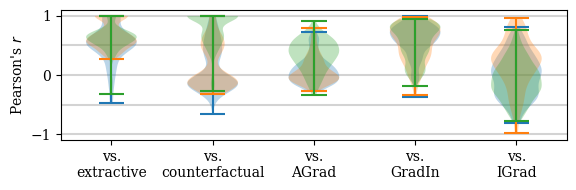

[<matplotlib.patches.Patch object at 0x7fac14498070>, <matplotlib.patches.Patch object at 0x7fac1439acb0>, <matplotlib.patches.Patch object at 0x7fac1439a8c0>]


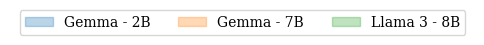

In [14]:
pearson.boxplot('human', path=f'{PLOTS_DIR}/PearsonViolin - Food Hazard - Human.pdf')

/home/h21/kora8563/explainability/resources/testing.py:190: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


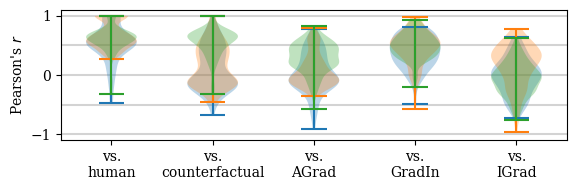

[<matplotlib.patches.Patch object at 0x7fac143f30d0>, <matplotlib.patches.Patch object at 0x7fac1426f6d0>, <matplotlib.patches.Patch object at 0x7fac1f86d870>]


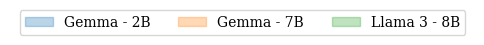

In [15]:
pearson.boxplot('extractive', path=f'{PLOTS_DIR}/PearsonViolin - Food Hazard - Self.pdf')

/home/h21/kora8563/explainability/resources/testing.py:190: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


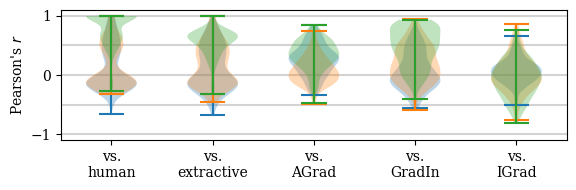

[<matplotlib.patches.Patch object at 0x7fac07ff36d0>, <matplotlib.patches.Patch object at 0x7fab95744c10>, <matplotlib.patches.Patch object at 0x7faa91e1f340>]


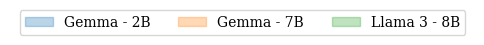

In [16]:
pearson.boxplot('counterfactual', path=f'{PLOTS_DIR}/PearsonViolin - Food Hazard - Counterfactual.pdf')

/home/h21/kora8563/explainability/resources/testing.py:190: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


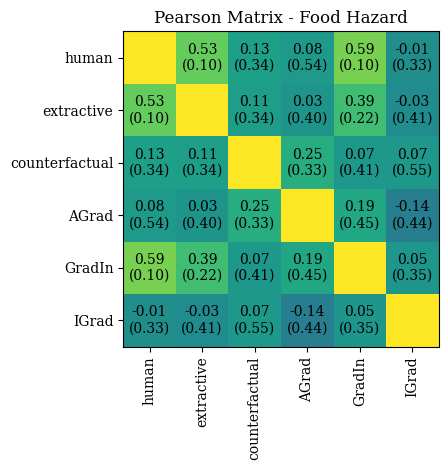

/home/h21/kora8563/explainability/resources/testing.py:190: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


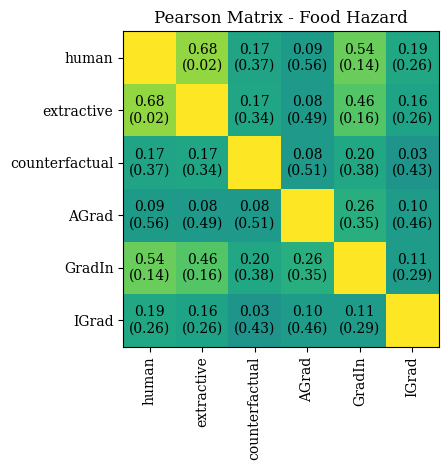

/home/h21/kora8563/explainability/resources/testing.py:190: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


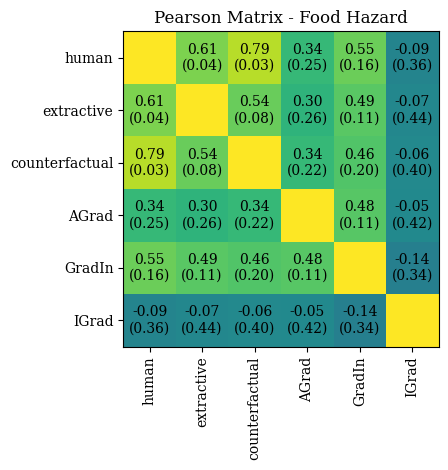

In [17]:
pearson.matrixplot(title='Pearson Matrix - Food Hazard', dir=PLOTS_DIR)

# Gradient Saturation:

Gemma - 2B
  mean: 8.597044964396248e-06
  std:  0.0016918658983987721
  min:  -0.02829833984375
  max:  0.03208099365234375

Gemma - 7B
  mean: 1.873802745217311e-05
  std:  0.012257020377557128
  min:  -0.26568603515625
  max:  0.198800048828125

Llama 3 - 8B
  mean: -5.036298395443945e-05
  std:  0.07573928211113451
  min:  -1.152626953125
  max:  1.108369140625



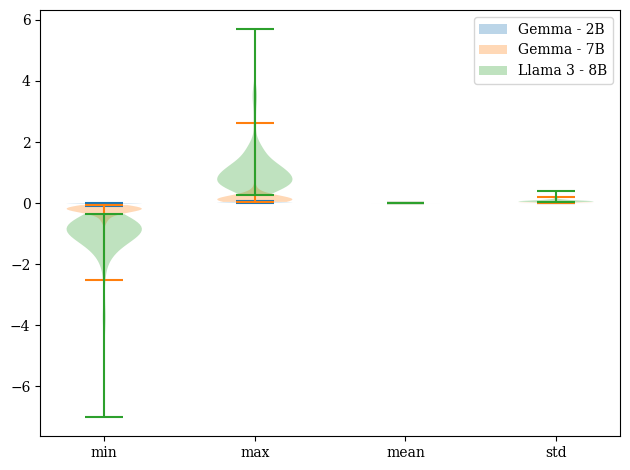

In [18]:
hs, ls = [], [] 
for model in RESULTS:
    grad_min = []
    grad_avg = []
    grad_std = []
    grad_max = []
    
    for r in RESULTS[model]:
        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']

        # get important window:
        grad = r['Grad'][0, :, start:end, :]
        
        grad_min.append(grad.min())
        grad_avg.append(grad.mean())
        grad_std.append(grad.std())
        grad_max.append(grad.max())
   
    hs.append(plt.violinplot([grad_min, grad_max, grad_avg, grad_std])['bodies'][0])
    ls.append(model)

    print(model)
    print('  mean:', np.mean(grad_avg))
    print('  std: ', np.mean(grad_std))
    print('  min: ', np.mean(grad_min))
    print('  max: ', np.mean(grad_max))
    print()

plt.xticks(ticks=[1, 2, 3, 4], labels=['min', 'max', 'mean', 'std'])
plt.legend(handles=hs, labels=ls)
plt.tight_layout()
plt.show()

# Counterfactual:

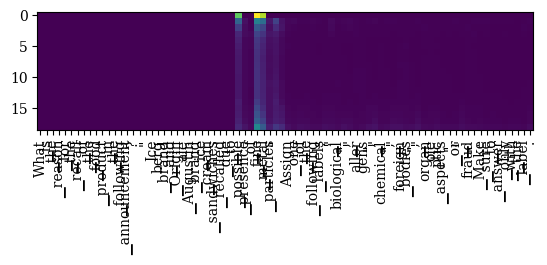

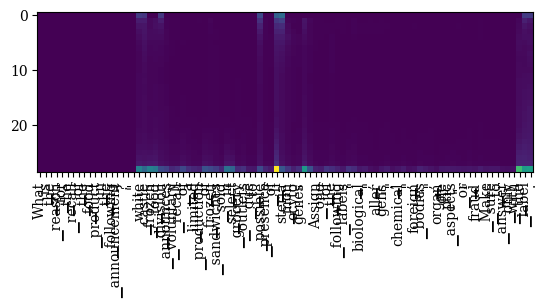

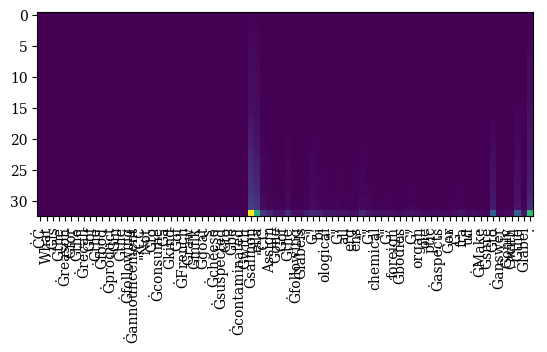

In [19]:
from sklearn.metrics import pairwise_distances

for model in RESULTS:
    r = np.random.choice(RESULTS[model])
    
    start = 4#r['sample']['start']
    end   = r['prediction']['index']-5#r['sample']['end']
    
    hs_cf = r['counterfactual']['hidden_states'][0,:,start:end]
    hs_r  = r['hidden_states'][0,:,start:end]

    err = []
    for layer in range(hs_cf.shape[0]):
        dist = pairwise_distances(hs_r[layer], hs_cf[layer], metric='euclidean')

        err.append(dist.min(axis=1))

    plt.imshow(err)
    plt.xticks(
        ticks    = range(end-start),
        labels   = r['tokens'][start:end],
        rotation = 90
    )
    plt.show()

/home/h21/kora8563/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Gemma - 2B
  Success rate: 0.065
  Similarity: 0.952922829420734
  ROUGE-1: 0.7841513872202822
  BLEU-1: 0.7442627529368516
  ROUGE-L: 0.7539556792952378
  BART: -2.298708915710449

Gemma - 7B
  Success rate: 0.68
  Similarity: 0.9503121793526583
  ROUGE-1: 0.7840331592558814
  BLEU-1: 0.7351986039074521
  ROUGE-L: 0.7516547825014669
  BART: -1.9567249881870605

Llama 3 - 8B
  Success rate: 0.36
  Similarity: 0.9705438852008916
  ROUGE-1: 0.8089831353367131
  BLEU-1: 0.8863994394838048
  ROUGE-L: 0.8424150976060738
  BART: -2.5808093200127282



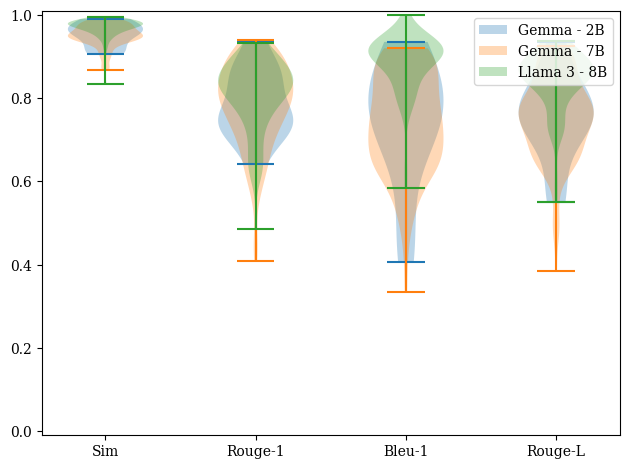

In [20]:
rouge_scorer = RougeScorer(['rouge1', 'rougeL'], tokenizer=WordPunctTokenizer())
bart_scorer = BARTScorer(device='cuda:0', checkpoint='facebook/bart-large-cnn')

hs, ls = [], [] 
for model in RESULTS:
    counterfactuals = []

    for r in RESULTS[model]:
        cf = r['counterfactual']
        success = cf['prediction'] != r['prediction']['text']
    
        rouge = rouge_scorer.score(r['sample']['text'].lower(), cf['text'].lower())
        bart = bart_scorer.score([r['sample']['text']], [cf['text'].lower()], batch_size=4)
        
        counterfactuals.append((
            int(success),
            cf['similarity'],
            rouge['rouge1'].recall,    # rouge
            rouge['rouge1'].precision, # bleu
            rouge['rougeL'].fmeasure,
            bart[0]
        ))
    
    counterfactuals = np.array(counterfactuals, dtype=float)

    hs.append(plt.violinplot(counterfactuals[counterfactuals[:,0] == 1., 1:-1])['bodies'][0])
    ls.append(model)

    print(model)
    print('  Success rate:', counterfactuals[:,0].mean())
    print('  Similarity:', counterfactuals[counterfactuals[:,0] == 1., 1].mean())
    print('  ROUGE-1:', counterfactuals[counterfactuals[:,0] == 1., 2].mean())
    print('  BLEU-1:', counterfactuals[counterfactuals[:,0] == 1., 3].mean())
    print('  ROUGE-L:', counterfactuals[counterfactuals[:,0] == 1., 4].mean())
    print('  BART:', counterfactuals[counterfactuals[:,0] == 1., 5].mean())
    print()

plt.ylim(bottom=-.01, top=1.01)
plt.xticks(ticks=[1, 2, 3, 4], labels=['Sim', 'Rouge-1', 'Bleu-1', 'Rouge-L'])
plt.legend(handles=hs, labels=ls)
plt.tight_layout()
plt.show()

# Saliency Maps:

In [21]:
r = results[0]

NameError: name 'results' is not defined

In [ ]:
plt.imshow(r['IGrad'][0].mean(axis=1).T)
plt.xticks(
    ticks    = range(len(r['tokens'])-1),
    labels   = r['tokens'][:-1],
    rotation = 90
)
plt.show()

In [ ]:
plt.imshow(r['AGrad'][0,0].mean(axis=0))
plt.yticks(
    ticks    = range(len(r['tokens'])-1),
    labels   = r['tokens'][1:],
)
plt.xticks(
    ticks    = range(len(r['tokens'])-1),
    labels   = r['tokens'][:-1],
    rotation = 90
)
plt.show()

In [ ]:
plt.imshow(r['GradIn'][:,0,:].mean(axis=-1))
plt.xticks(
    ticks    = range(len(r['tokens'])-1),
    labels   = r['tokens'][:-1],
    rotation = 90
)
plt.show()